# customer_churn_project_english

It is necessary to predict whether the client will leave the bank in the near future or not. We have been provided with historical data on customer behavior and termination of agreements with the bank.

Let us construct a model with an extremely large *F1*-measure. To pass the project successfully, you need to bring the metric to 0.59. Check the *F1*-measure on the test set.

Additionally, we measure *AUC-ROC*, compare its value with *F1*-measure.

Data source: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Data preparation

### Import libraries

In [1]:
!pip install catboost
!pip install imblearn

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re as re

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_score, recall_score, precision_recall_curve, accuracy_score
from sklearn.utils import shuffle

from catboost import CatBoostClassifier
from catboost import Pool, cv

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import warnings
warnings.filterwarnings("ignore")


In [2]:
data = pd.read_csv('/media/aleksey/A6B828A60EB3956D/Data science/Специалист Data scinties/Обучение с учителем/Churn_Modelling.csv')
data.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


### Data exploration Churn_Modelling.csv

In [4]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


**Features:**

RowNumber - the index of the row in the data  
CustomerId - unique customer identifier  
Surname - surname  
CreditScore - credit rating  
Geography - country of residence  
Gender - gender  
Age - age  
Tenure - how many years a person has been a client of the bank  
Balance - account balance  
NumOfProducts - the number of bank products used by the client   
HasCrCard - availability of a credit card  
IsActiveMember - client activity  
EstimatedSalary - estimated salary  
Target column:  

Exited - the fact of the client's departure  


In [5]:
data.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in data.columns]#Let's convert the names of the columns to the snake register
data.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

In [6]:
data.columns = ['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited']#Let's convert the names of the columns to the snake register
data.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        10000 non-null  int64  
 1   customer_id       10000 non-null  int64  
 2   surname           10000 non-null  object 
 3   credit_score      10000 non-null  int64  
 4   geography         10000 non-null  object 
 5   gender            10000 non-null  object 
 6   age               10000 non-null  int64  
 7   tenure            10000 non-null  int64  
 8   balance           10000 non-null  float64
 9   num_of_products   10000 non-null  int64  
 10  has_cr_card       10000 non-null  int64  
 11  is_active_member  10000 non-null  int64  
 12  estimated_salary  10000 non-null  float64
 13  exited            10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


### Consider the presence of rare and outliers by analyzing through the method .describe()

In [8]:
data.describe(include='all')

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
count,10000.00000,1.000000e+04,10000,10000.000000,10000,10000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
unique,NaN,NaN,2932,NaN,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Smith,NaN,France,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,32,NaN,5014,5457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,5000.50000,1.569094e+07,NaN,650.528800,NaN,NaN,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,NaN,96.653299,NaN,NaN,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,NaN,350.000000,NaN,NaN,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,NaN,584.000000,NaN,NaN,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,NaN,652.000000,NaN,NaN,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,NaN,718.000000,NaN,NaN,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000


* No anomalies

In [9]:
data.groupby('exited')['customer_id'].count()# consider the target feature. One in four leaves the bank

exited
0    7963
1    2037
Name: customer_id, dtype: int64

In [10]:
data[data['balance']==0].groupby('exited')['customer_id'].count()# Every sixth client with a zero balance leaves the bank

exited
0    3117
1     500
Name: customer_id, dtype: int64

### Check for duplicates

In [11]:
data.duplicated().sum()

0

### Remove non-informative columns not needed for the model row_number, customer_id, surname

In [12]:
data = data.drop(['row_number', 'customer_id', 'surname'], axis=1).copy()
data.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


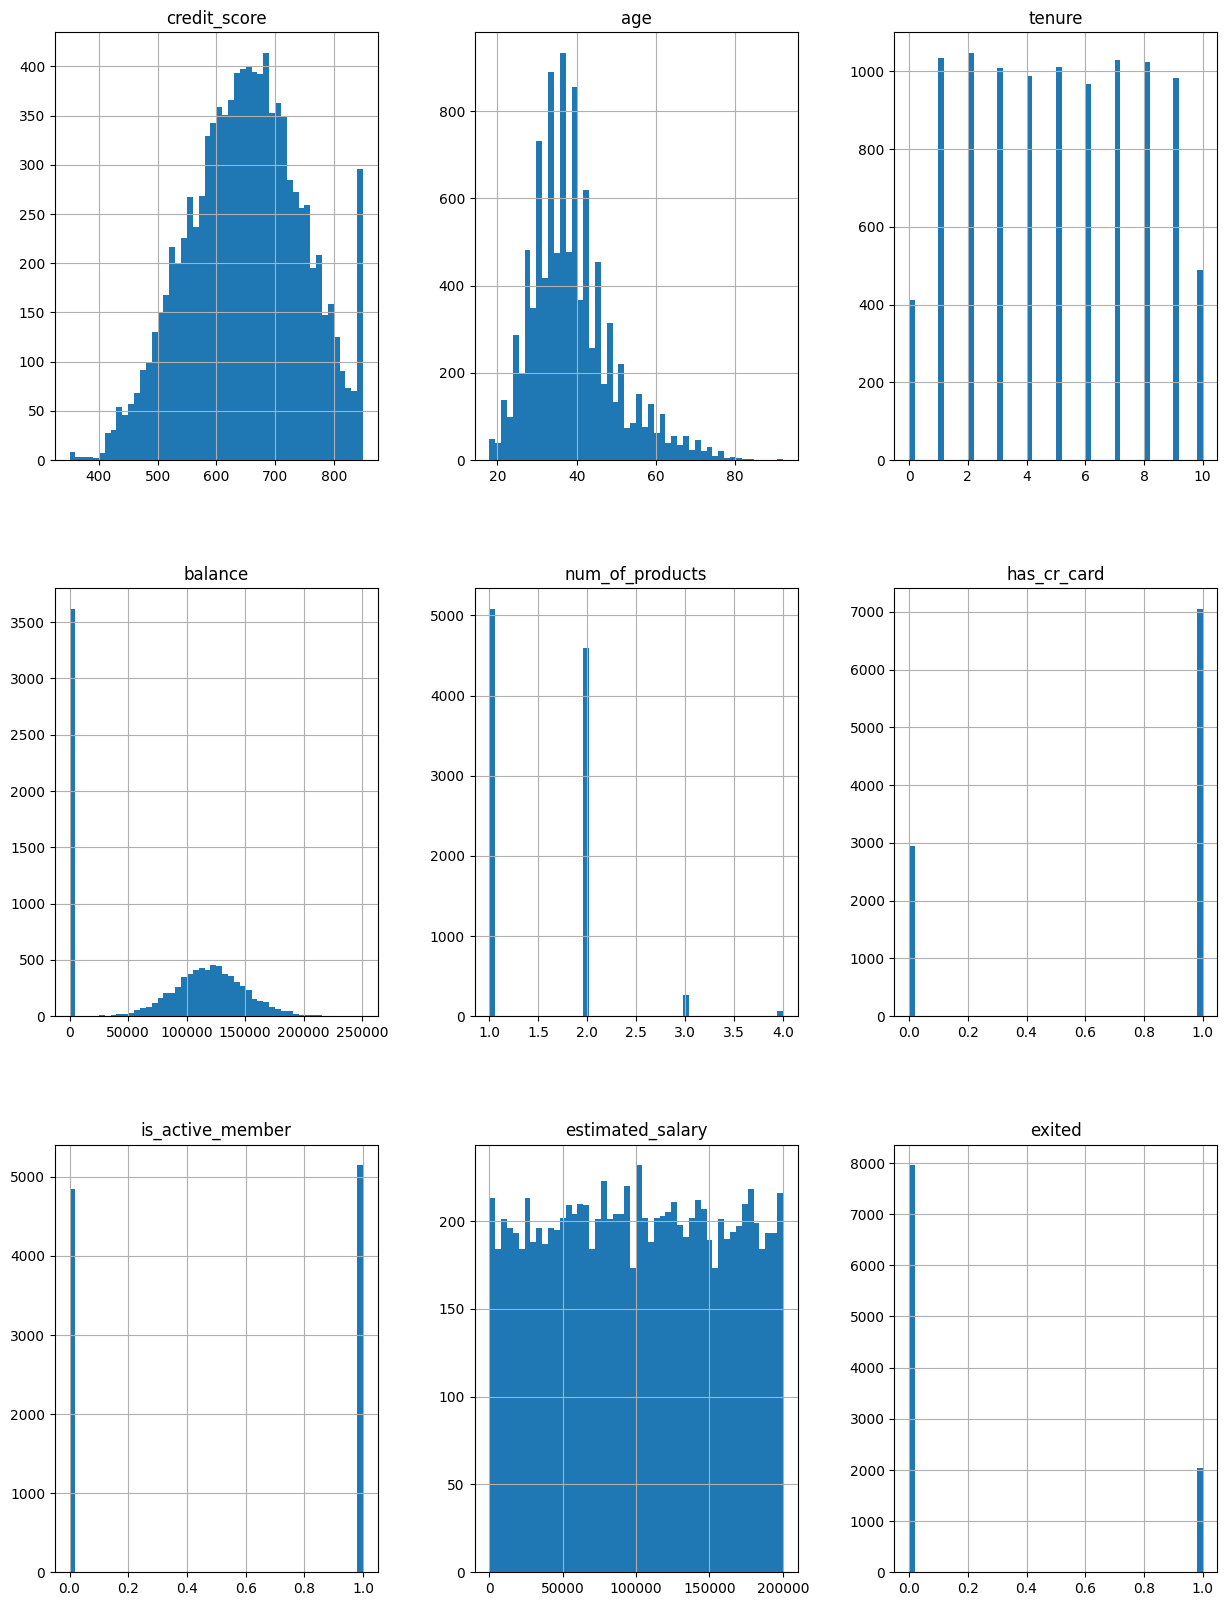

In [13]:
data.hist(bins=50, figsize=(15, 20))#built a common histogram for all numeric columns
plt.show()

### Findings

1. Out of 10,000 customers, 2,037 customers left the bank.
2. Column names are changed to snake and lowercase
3. Anomalies were not detected
4. There is an imbalance of classes. The number of customer exits is approximately four times less than the remaining
5. People with zero balances are more likely to leave the bank

## Problem research

Clients started leaving the bank. A little, but noticeable. Banking marketers figured it was cheaper to keep current customers than to attract new ones.
It is necessary to predict whether the client will leave the bank in the near future or not.
1. Let us construct a model with an extremely large value of the F1-measure. Let's check the F1-measure on the test sample.
2. Additionally, we measure the AUC-ROC, compare its value with the F1-measure.
3. We have an imbalance of classes, correctness (accuracy) does not suit us.
To solve this problem, I propose to use the algorithms of Logistic Regression, Random Forest and Decision Tree, Catboost

### One-hot Encoding

In [14]:
def unique_values(data):
    for column in data : 
        if data[column].dtypes == 'object':
            print(f'{column}:{data[column].unique()}:{len(data[column].unique())}')
unique_values(data)

geography:['France' 'Spain' 'Germany']:3
gender:['Female' 'Male']:2


Converting categorical features to numerical will help the direct coding technique, or One-Hot Encoding display.
The OHE technique converts categorical features into numerical features in two stages:
1. A new column is created for each characteristic value;
2. If the category is suitable for the object, 1 is assigned, if not, 0.
The new features are called dummy variables, or dummy features.
For direct encoding, the pandas library has the pd.get_dummies() function.
Let's convert the categorical features of the gender and geography columns with the One-hot Encoding method into numerical ones.

In [15]:
data.groupby('gender')['estimated_salary'].count()# consider the target feature

gender
Female    4543
Male      5457
Name: estimated_salary, dtype: int64

In [16]:
data.groupby('geography')['estimated_salary'].count()#consider the target feature

geography
France     5014
Germany    2509
Spain      2477
Name: estimated_salary, dtype: int64

In [17]:
data['gender'] = pd.get_dummies(data["gender"], drop_first=True)

In [18]:
pd.get_dummies(data["geography"], drop_first=True)

,Germany,Spain
0,0,0
1,0,1
2,0,0
3,0,0
4,0,1
...,...,...
9995,0,0
9996,0,0
9997,0,0
9998,1,0


In [19]:
data_ohe = pd.get_dummies(data["geography"], drop_first=True)

In [20]:
data = pd.concat([data, data_ohe], axis=1)#add new columns from geography

data.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,Germany,Spain
0,619,France,0,42,2,0.00,1,1,1,101348.88,1,0,0
1,608,Spain,0,41,1,83807.86,1,0,1,112542.58,0,0,1
2,502,France,0,42,8,159660.80,3,1,0,113931.57,1,0,0
3,699,France,0,39,1,0.00,2,0,0,93826.63,0,0,0
4,850,Spain,0,43,2,125510.82,1,1,1,79084.10,0,0,1


In [21]:
data = data.drop(['geography'], axis=1).copy()#remove the geography column
data.head()

,credit_score,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,Germany,Spain
0,619,0,42,2,0.00,1,1,1,101348.88,1,0,0
1,608,0,41,1,83807.86,1,0,1,112542.58,0,0,1
2,502,0,42,8,159660.80,3,1,0,113931.57,1,0,0
3,699,0,39,1,0.00,2,0,0,93826.63,0,0,0
4,850,0,43,2,125510.82,1,1,1,79084.10,0,0,1


### Divide the data into samples

In [22]:
# separate 20% of the data for the test sample of the sample (for model validation)

In [23]:
target = data['exited']
features = data.drop(['exited'] , axis=1)
features_other, features_test, target_other, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345)

In [24]:
# separate 25% of the data (from other) to split into training and validation sets

In [25]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features_other, target_other, test_size=0.25, random_state=12345)

In [26]:
print('Training sample size', len(features_train))
print('Validation sample size', len(features_valid))
print('Test sample size', len(features_test))

Training sample size 6000
Validation sample size 2000
Test sample size 2000


### Feature scaling

If the data contains quantitative features with different ranges of values, then the algorithm may decide that features with large values and ranges are more important.   To avoid this
traps, signs are scaled - brought to the same scale.

In [27]:
numeric = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_train.head()

,credit_score,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,Germany,Spain
492,-0.134048,0,-0.078068,-0.357205,0.076163,0.816929,0,1,0.331571,0,0
6655,-1.010798,1,0.494555,0.676673,0.136391,-0.896909,1,1,-0.727858,0,0
4287,0.639554,1,1.353490,-1.391083,0.358435,-0.896909,1,1,-0.477006,1,0
42,-0.990168,0,2.116987,-1.046457,0.651725,-0.896909,1,1,-0.100232,0,0
8178,0.567351,0,0.685430,0.676673,0.813110,0.816929,1,1,0.801922,0,0


In [28]:
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_valid.head()

,credit_score,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,Germany,Spain
2358,0.175393,1,0.399118,-1.391083,1.385698,-0.896909,0,1,-1.466761,0,0
8463,-1.299609,1,0.971741,-1.046457,-1.232442,-0.896909,1,0,0.254415,0,1
163,0.711757,0,-0.268942,-1.046457,-1.232442,0.816929,1,1,0.122863,0,1
3074,-0.391916,0,0.494555,0.332047,0.672529,-0.896909,1,0,0.585847,1,0
5989,0.165078,0,1.353490,1.710552,0.536522,-0.896909,0,0,1.462457,0,0


In [29]:
features_test[numeric] = scaler.transform(features_test[numeric])
features_test.head()

,credit_score,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,Germany,Spain
7867,-0.123733,0,0.685430,-0.701831,-1.232442,-0.896909,1,1,0.980212,0,1
1402,1.083087,1,-0.937002,1.021300,0.858518,-0.896909,1,0,-0.390486,0,0
8606,1.598822,1,0.303681,-0.012579,-1.232442,0.816929,1,1,-0.435169,0,1
8885,0.165078,1,0.589993,-0.357205,0.412100,0.816929,1,1,1.017079,0,1
6494,0.484834,1,-1.032439,0.676673,-1.232442,0.816929,1,1,-1.343558,0,0


### Examining models without imbalance

In [30]:
#for the convenience of output in the future - we will collect the indicators in lists
tabl_model = []
tabl_prec = []
tabl_not = []
tabl_roc_auc = []

#### Logistic Regression Model

In [31]:
model = LogisticRegression(solver = 'liblinear', penalty = 'l2', multi_class ='auto', fit_intercept=True, dual=False, C=10,
                           random_state=12345, max_iter=1000) 
model.fit(features_train, target_train) # train the model on the training data
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))# calculate the quality of the model on the validation set

probabilities_valid = model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("AUC_ROC = {:.3f}\n".format(auc_roc))


F1: 0.30393996247654786
AUC_ROC = 0.770



In [32]:
tabl_prec.append(round(f1_score(target_valid, predicted_valid), 2))
tabl_roc_auc.append(round(auc_roc, 2))
tabl_model.append('LogisticRegression')
tabl_not.append('without_imbalance')


Small value F1. We will select parameters and disassemble with an imbalance later

#### Decision tree model

In [33]:
%%time
1 + 1
best_model = None
best_result = 0
for depth in range(1, 15):
	model = DecisionTreeClassifier(max_depth=depth) # train the model with a given tree depth
	model.fit(features_train, target_train) 
	predicted_valid = model.predict(features_valid)
	result = f1_score(target_valid, predicted_valid) 
	if result > best_result:
		best_model = model
		best_result = result

print("F1 best model:", best_result)
print("max_depth best model:", best_model)

probabilities_valid = best_model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("AUC_ROC = {:.3f}\n".format(auc_roc))

F1 best model: 0.5520504731861199
max_depth best model: DecisionTreeClassifier(max_depth=7)
AUC_ROC = 0.820

CPU times: user 436 ms, sys: 72 ms, total: 508 ms
Wall time: 359 ms


In [34]:
tabl_prec.append(round((best_result), 2))
tabl_roc_auc.append(round(auc_roc, 2))
tabl_model.append('DecisionTreeClassifier')
tabl_not.append('without_imbalance')



Much better, but consider other models

#### Random forest model

In [35]:
%%time
1 + 1

best_result = 0
for est in range(10, 101, 10):     
    for depth in range(1, 30):
        for samples_split in range(2, 51, 10):
            model = RandomForestClassifier(max_depth=depth, min_samples_split=samples_split, n_estimators=est, random_state=12345)
            model.fit(features_train, target_train) 
            predicted_valid = model.predict(features_valid) 
            result = f1_score(target_valid, predicted_valid)
            if result > best_result:
                best_model = model
                best_result = result

KeyboardInterrupt: 

In [36]:
best_model

RandomForestClassifier(max_depth=17, min_samples_split=12, n_estimators=30,
                       random_state=12345)

In [37]:
best_result

0.5819935691318328

In [38]:
print("F1:", best_result)
tabl_prec.append(round(best_result, 2))

probabilities_valid = best_model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("AUC_ROC = {:.3f}\n".format(auc_roc))

tabl_roc_auc.append(round(auc_roc, 2))
tabl_model.append('RandomForestClassifier')
tabl_not.append('without_imbalance')

F1: 0.5819935691318328
AUC_ROC = 0.843



This RandomForestClassifier model has the best result so far

#### CatBoostClassifier

In [39]:
model = CatBoostClassifier(verbose=100, random_state=12345)
model.fit(features_train, target_train)

predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("AUC_ROC = {:.3f}\n".format(auc_roc))

Learning rate set to 0.022141
0:	learn: 0.6754999	total: 57.5ms	remaining: 57.4s
100:	learn: 0.3343972	total: 304ms	remaining: 2.71s
200:	learn: 0.3110064	total: 498ms	remaining: 1.98s
300:	learn: 0.2963858	total: 682ms	remaining: 1.58s
400:	learn: 0.2844886	total: 860ms	remaining: 1.28s
500:	learn: 0.2741070	total: 1.06s	remaining: 1.05s
600:	learn: 0.2646223	total: 1.25s	remaining: 830ms
700:	learn: 0.2550124	total: 1.47s	remaining: 628ms
800:	learn: 0.2456157	total: 1.67s	remaining: 414ms
900:	learn: 0.2361567	total: 1.85s	remaining: 203ms
999:	learn: 0.2277176	total: 2.04s	remaining: 0us
F1: 0.596875
AUC_ROC = 0.864



In [40]:
tabl_prec.append(round(f1_score(target_valid, predicted_valid), 2))
tabl_roc_auc.append(round(auc_roc, 2))
tabl_model.append('CatBoostClassifier')
tabl_not.append('without_imbalance')

F1 measure is larger than in all other models

In [41]:
table_models = (pd.DataFrame({'Model':tabl_model, 'F1 score':tabl_prec, 'ROC-AUC':tabl_roc_auc, 'Notice': tabl_not}).sort_values(by='F1 score', ascending=False).
                  reset_index(drop=True))
table_models

,Model,F1 score,ROC-AUC,Notice
0,CatBoostClassifier,0.60,0.86,without_imbalance
1,RandomForestClassifier,0.58,0.84,without_imbalance
2,DecisionTreeClassifier,0.55,0.82,without_imbalance
3,LogisticRegression,0.30,0.77,without_imbalance


### Findings

1. Transformed categorical features into numerical ones using direct coding technique, or One-Hot Encoding mapping.
2. Divided the data into samples in the ratio 60-20-20
3. Brought signs to a single scale to avoid the trap
4. We studied the models without taking into account the imbalance. The models CatBoostClassifier, RandomForestClassifier performed best
5. Compared parameters f1 and ROC-AUC models

## Struggling with imbalance

In [42]:
data.groupby('exited')['exited'].count()# Let's look at the target. One in four leaves the bank. There is a class imbalance

exited
0    7963
1    2037
Name: exited, dtype: int64

### class_weight='balanced'

#### Logistic Regression Model

In [43]:
model = LogisticRegression(solver = 'liblinear', penalty = 'l2', multi_class ='auto', fit_intercept=True, dual=False, C=10,
                           random_state=12345, max_iter=1000, class_weight='balanced') 
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("AUC_ROC = {:.3f}\n".format(auc_roc))

F1: 0.4821428571428571
AUC_ROC = 0.772



In [44]:
tabl_prec.append(round(f1_score(target_valid, predicted_valid), 2))
tabl_roc_auc.append(round(auc_roc, 2))
tabl_model.append('LogisticRegression')
tabl_not.append('class_weight')

#### Decision tree model

In [45]:
%%time
1 + 1
best_model = None
best_result = 0
for depth in range(1, 15):
	model = DecisionTreeClassifier(max_depth=depth, random_state=12345, class_weight='balanced') 
	model.fit(features_train, target_train)
	predicted_valid = model.predict(features_valid)
	result = f1_score(target_valid, predicted_valid) 
	if result > best_result:
		best_model = model
		best_result = result

print("F1 best model:", best_result)
print("max_depth best model best_model)

probabilities_valid = best_model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("AUC_ROC = {:.3f}\n".format(auc_roc))

SyntaxError: EOL while scanning string literal (<unknown>, line 14)

In [ ]:
tabl_prec.append(round((best_result), 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('DecisionTreeClassifier')
tabl_not.append('class_weight')

#### Random forest model

In [ ]:
%%time
1 + 1

model = RandomForestClassifier(class_weight='balanced', max_depth=17, min_samples_leaf=2, min_samples_split=12,
                       n_estimators=30,random_state=12345)

model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = best_model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("AUC_ROC = {:.3f}\n".format(auc_roc))

In [ ]:
tabl_prec.append(round(f1_score(target_valid, predicted_valid), 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('RandomForestClassifier')
tabl_not.append('class_weight')

By adding the class_weight='balanced' parameter, a rare class will have more weight.

In [ ]:
table_models = (pd.DataFrame({'Model':tabl_model, 'F1 score':tabl_prec, 'ROC-AUC':tabl_roc_auc, 'Notice': tabl_not}).sort_values(by='F1 score', ascending=False).
                  reset_index(drop=True))
table_models

#### Comparison:

Two models (DecisionTreeClassifier, LogisticRegression) increased the F1 measure and the ROC-AUC indicator using the class_weight='balanced' parameter

### upsampling.

In [ ]:
oversample = SMOTE(random_state=12345)

In [ ]:
features_upsampled, target_upsampled = oversample.fit_resample(features_train, target_train)

In [ ]:
print('Upsampled validation sample size', len(features_upsampled))

#### Logistic Regression Model

In [ ]:
model = LogisticRegression(solver='liblinear', random_state=12345)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("AUC_ROC = {:.3f}\n".format(auc_roc))

In [ ]:
tabl_prec.append(round(f1_score(target_valid, predicted_valid), 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('LogisticRegression')
tabl_not.append('upsampling')

#### Decision tree model

In [ ]:
%%time
1 + 1
best_model = None
best_result = 0
for depth in range(1, 15):
	model = DecisionTreeClassifier(max_depth=depth)
	model.fit(features_upsampled, target_upsampled) 
	predicted_valid = model.predict(features_valid) 
	result = f1_score(target_valid, predicted_valid) 
	if result > best_result:
		best_model = model
		best_result = result

print("F1 best model:", best_result)
print("max_depth лучшей модели:", best_model)

probabilities_valid = best_model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("AUC_ROC = {:.3f}\n".format(auc_roc))


In [ ]:
tabl_prec.append(round((best_result), 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('DecisionTreeClassifier')
tabl_not.append('upsampling')

#### Random forest model.

In [ ]:
%%time
1 + 1
model = RandomForestClassifier(max_depth=17, min_samples_leaf=2, min_samples_split=12,
                       n_estimators=30, random_state=12345)

model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("AUC_ROC = {:.3f}\n".format(auc_roc))

In [ ]:
tabl_prec.append(round(f1_score(target_valid, predicted_valid), 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('RandomForestClassifier')
tabl_not.append('upsampling')

#### CatBoostClassifier

In [ ]:
model = CatBoostClassifier(verbose=100, random_state=12345)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

auc_roc = roc_auc_score(target_valid, predicted_valid)
print('ROC-AUC:', auc_roc)

In [ ]:
tabl_prec.append(round(f1_score(target_valid, predicted_valid), 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('CatBoostClassifier')
tabl_not.append('upsampling')

In [ ]:
table_models = (pd.DataFrame({'Model':tabl_model, 'F1 score':tabl_prec, 'ROC-AUC':tabl_roc_auc, 'Notice': tabl_not}).sort_values(by='F1 score', ascending=False).
                  reset_index(drop=True))
table_models

#### Comparison:

By increasing the sample, we improved the LogisticRegression, DecisionTreeClassifier model. For CatBoostClassifier and RandomForestClassifier models, values are worse than before debalancing

### downsampling. Sample reduction

In [ ]:
downsample = RandomUnderSampler(random_state=12345)

In [ ]:
features_downsampled, target_downsampled = downsample.fit_resample(features_train, target_train)

In [ ]:
print('Size of the downsampled validation sample', len(features_downsampled))

#### Logistic Regression Model

In [ ]:
model = LogisticRegression(solver='liblinear', random_state=12345)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("AUC_ROC = {:.3f}\n".format(auc_roc))

In [ ]:
tabl_prec.append(round(f1_score(target_valid, predicted_valid), 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('LogisticRegression')
tabl_not.append('downsampled')

#### Decision tree model

In [ ]:
%%time
1 + 1
best_model = None
best_result = 0
for depth in range(1, 15):
	model = DecisionTreeClassifier(max_depth=depth) 
	model.fit(features_downsampled, target_downsampled) 
	predicted_valid = model.predict(features_valid) 
	result = f1_score(target_valid, predicted_valid) 
	if result > best_result:
		best_model = model
		best_result = result

print("F1 best model:", best_result)
print("max_depth best model:", best_model)

probabilities_valid = best_model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("AUC_ROC = {:.3f}\n".format(auc_roc))


In [ ]:
tabl_prec.append(round((best_result), 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('DecisionTreeClassifier')
tabl_not.append('downsampled')

#### Random forest model

In [ ]:
%%time
1 + 1
model = RandomForestClassifier(max_depth=17, min_samples_leaf=2, min_samples_split=12,
                       n_estimators=30, random_state=12345)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("AUC_ROC = {:.3f}\n".format(auc_roc))

In [ ]:
tabl_prec.append(round(f1_score(target_valid, predicted_valid), 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('RandomForestClassifier')
tabl_not.append('downsampled')

#### CatBoostClassifier

In [ ]:
model = CatBoostClassifier(verbose=100, random_state=12345)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("AUC_ROC = {:.3f}\n".format(auc_roc))

In [ ]:
tabl_prec.append(round(f1_score(target_valid, predicted_valid), 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('CatBoostClassifier')
tabl_not.append('downsampled')

In [ ]:
table_models = (pd.DataFrame({'Model':tabl_model, 'F1 score':tabl_prec, 'ROC-AUC':tabl_roc_auc, 'Notice': tabl_not}).sort_values(by='F1 score', ascending=False).
                  reset_index(drop=True))
table_models

#### Comparison:

Significantly worse performance for all models except LogisticRegression.

### Changing the qualification threshold

The boundary where the negative class ends and the positive class begins is called the threshold. By default it is 0.5, but you can change it.

#### Logistic Regression Model

In [ ]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)[:, 1]

best_f1 = 0
for threshold in np.arange(0, 0.95, 0.05):
    predicted_valid = probabilities_valid > threshold 
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    F1 = f1_score(target_valid, predicted_valid)
    print("threshold = {:.2f} | precision = {:.3f}, recall = {:.3f}, F1 = {:.3f}".format(threshold, precision, recall, F1))
    if F1>best_f1:
        best_f1 = F1

auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("ROC-AUC = {:.3f}".format(auc_roc))     
print("F1-мера = {:.3f}".format(best_f1))

In [ ]:
probabilities_valid = model.predict_proba(features_valid)
precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid[:, 1])

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Curve Precision-Recall')

plt.show()

For a threshold of 0.30, the highest F1 and ROC-AUC

In [ ]:
tabl_prec.append(round(best_f1, 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('LogisticRegression')
tabl_not.append('threshold=0.3')

In [ ]:
table_models = (pd.DataFrame({'Model':tabl_model, 'F1 score':tabl_prec, 'ROC-AUC':tabl_roc_auc, 'Notice': tabl_not}).sort_values(by='F1 score', ascending=False).
                  reset_index(drop=True))
table_models

#### Decision tree model

In [ ]:
%%time
1 + 1
model = DecisionTreeClassifier(max_depth=5) 
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)[:, 1]

best_f1 = 0
for threshold in np.arange(0, 0.95, 0.05):
    predicted_valid = probabilities_valid > threshold 
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    F1 = f1_score(target_valid, predicted_valid)
    print("threshold = {:.2f} | precision = {:.3f}, recall = {:.3f}, F1 = {:.3f}".format(threshold, precision, recall, F1))
    if F1>best_f1:
        best_f1 = F1

auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("ROC-AUC = {:.3f}".format(auc_roc))     
print("F1-мера = {:.3f}".format(best_f1))

In [ ]:
probabilities_valid = model.predict_proba(features_valid)
precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid[:, 1])

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Curve Precision-Recall')
plt.show()

For a threshold of 0.4, the highest F1

In [ ]:
tabl_prec.append(round(best_f1, 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('DecisionTreeClassifier')
tabl_not.append('threshold=0.4')

In [ ]:
table_models = (pd.DataFrame({'Model':tabl_model, 'F1 score':tabl_prec, 'ROC-AUC':tabl_roc_auc, 'Notice': tabl_not}).sort_values(by='F1 score', ascending=False).
                  reset_index(drop=True))
table_models

#### Random forest model

In [ ]:
%%time
1 + 1
model = RandomForestClassifier(max_depth=17, min_samples_leaf=2, min_samples_split=12,
                       n_estimators=30, random_state=12345)

model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)[:, 1]

best_f1 = 0 

for threshold in np.arange(0, 0.95, 0.05):
    predicted_valid = probabilities_valid > threshold 
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    F1 = f1_score(target_valid, predicted_valid)
    print("threshold = {:.2f} | precision = {:.3f}, recall = {:.3f}, F1 = {:.3f}".format(threshold, precision, recall, F1))
    if F1>best_f1:
        best_f1 = F1

auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("ROC-AUC = {:.3f}".format(auc_roc))     
print("F1-мера = {:.3f}".format(best_f1)) 

In [ ]:
probabilities_valid = model.predict_proba(features_valid)
precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid[:, 1])

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Curve Precision-Recall')
plt.show()

For a threshold of 0.35, the highest F1

In [ ]:
tabl_prec.append(round(best_f1, 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('RandomForestClassifier')
tabl_not.append('threshold=0.35')

In [ ]:
%%time
1 + 1
model = CatBoostClassifier(verbose=100, random_state=12345)

model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)[:, 1]

best_f1 = 0 

for threshold in np.arange(0, 0.95, 0.05):
    predicted_valid = probabilities_valid > threshold 
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    F1 = f1_score(target_valid, predicted_valid)
    print("threshold = {:.2f} | precision = {:.3f}, recall = {:.3f}, F1 = {:.3f}".format(threshold, precision, recall, F1))
    if F1>best_f1:
        best_f1 = F1

auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("ROC-AUC = {:.3f}".format(auc_roc))     
print("F1-мера = {:.3f}".format(best_f1)) 

In [ ]:
probabilities_valid = model.predict_proba(features_valid)
precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid[:, 1])

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Curve Precision-Recall')
plt.show()

The highest score with a threshold of 0.25

In [ ]:
tabl_prec.append(round(best_f1, 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('CatBoostClassifier')
tabl_not.append('threshold=0.25')

In [ ]:
table_models = (pd.DataFrame({'Model':tabl_model, 'F1 score':tabl_prec, 'ROC-AUC':tabl_roc_auc, 'Notice': tabl_not}).sort_values(by='F1 score', ascending=False).
                  reset_index(drop=True))
table_models

#### Comparison:

Changing the qualification threshold was able to significantly improve the models.

## Conclusion

<div class="alert alert-info"> <b>
We have determined the two most successful models - CatBoostClassifier with the best F1-measure and ROC-AUC measure obtained with threshold=0.25 and RandomForestClassifier with threshold 0.3. Let's try to find the optimal hyperparameters for it.

     1. In addition, we found that if there is an imbalance for our task, the best option is to change the threshold for RandomForestClassifier and a little for CatBoostClassifier.
     2. The increase in the sample proved to be better than its decrease. But not suitable for CatBoostClassifier and RandomForestClassifier
</div>

## Hyperparameter optimization for random forest model

### Stage 1. RandomizedSearchCV

You can start with the RandomizedSearchCV algorithm, which allows you to pretty roughly explore wide ranges of values. We will check on the sample (other), with the class_weight = {1:3.5} parameter using cross-validation. We get the base model, we will check it by the F1-measure.

In [ ]:
%%time
1 + 1
n_estimators = [int(x) for x in np.linspace(start = 2, stop = 100, num = 25)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 20, num = 20)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 25)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 25)]
bootstrap = [True, False]
class_weight = [{1:3.5}, {1:3.6}, {1:3.4},]
#As we work, we generate a param_dist entity containing, for each hyperparameter, the range of values to be tested
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
             'class_weight': class_weight}
model = RandomizedSearchCV(RandomForestClassifier(), 
                        param_dist, 
                        n_iter = 100, 
                        cv = 5, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=12345,
                        scoring = 'f1')
model.fit(features_other, target_other)

* With parameter values n_iter = 100 and cv = 5, we created 500 RF models by randomly selecting combinations of the above hyperparameters
* In order to find out in what range of values it is worth continuing the search, we can easily get a dataframe containing the results of the RandomizedSearchCV algorithm.

In [ ]:
rs_df = pd.DataFrame(model.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
rs_df

Now let's create bar graphs, on which, along the x-axis, the values of hyperparameters are located, and along the y-axis, the average values shown by the models. This will allow you to understand which hyperparameter values, on average, perform best.

In [ ]:
fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(40,20)
sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim([.5,.62])
axs[0,0].set_title('n_estimators')

sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim([.59,.62])
axs[0,1].set_title('min_samples_split')

sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_ylim([.59,.62])
axs[0,2].set_title('min_samples_leaf')

sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,0], color='wheat')
axs[1,0].set_ylim([.57,.62])
axs[1,0].set_title('max_features')

sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1], color='lightpink')
axs[1,1].set_ylim([.57,.62])
axs[1,1].set_title('max_depth')

sns.barplot(x='param_bootstrap',y='mean_test_score', data=rs_df, ax=axs[1,2], color='skyblue')
axs[1,2].set_ylim([.57,.62])
axs[1,2].set_title('bootstrap')

plt.show()

Analyzing the graphs, you can see some patterns:
1. n_estimators - choose the best parameters 55, 67, 83
2. min_samples_split - choose the best parameters 12, 16, 36
3. min_samples_leaf - choose the best parameters 4, 8, 12.
4. max_features - variant of log2 and sqrt
5. max_depth - choose the best parameters 10, 15, 18
6. bootstrap - True and False option

### Stage 2. Hyperparameter optimization. GridSearchCV

In [ ]:
%%time
1 + 1
n_estimators = [55, 67, 83]
max_features = ['log2', 'sqrt']
max_depth = [10, 15, 18]
min_samples_split = [12, 16, 36]
min_samples_leaf = [4, 8, 12]
bootstrap = [True, False]
class_weight = [{1:3.5}, {1:3.6}, {1:3.4},]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
             'class_weight': class_weight}
model = GridSearchCV(RandomForestClassifier(), 
                     param_dist, 
                     cv = 3, 
                     verbose = 1, 
                     n_jobs=-1)
model.fit(features_other, target_other)

The best model is stored in the best_estimator_ attribute

gsearch.best_estimator_
The score of the best model obtained through cross-validation is stored in the best_score_ attribute

gsearch.best_score_
The parameters of the best model are stored in the attribute best_params_

gsearch.best_params_
Thus, having once trained the GridSearchCV object, we immediately get both the best model and the best hyperparameters and the model score obtained using cross-validation. And there is no need for additional training of the model and determination of metrics for the selected validation set.

In [ ]:
model.best_estimator_

In [ ]:
model.best_score_

Above the threshold of 0.59 on the validation set and the test set. Let's try on a test sample and see how the model behaves on unfamiliar data

## Hyperparameter optimization for the CatBoostClassifier model

Let's try to set up Catboost using cross-validation. We get the base model, we will check it by the F1-measure. Taking into account the imbalance of classes class_weights = [1, 0.25]

In [ ]:
model_cat = CatBoostClassifier(custom_loss=['F1'], random_seed=12345, logging_level='Silent', class_weights = [1, 0.25])

In [ ]:
model_cat.fit(features_train, target_train, eval_set=(features_valid, target_valid))

Let's cross-validate using the built-in Pool function

In [ ]:
cv_params = model_cat.get_params()
cv_params.update({'loss_function': 'Logloss'})
cv_data = cv(Pool(features_train, target_train),cv_params)

In [ ]:
cv_params

In [ ]:
print('F1-мера: {}'.format(np.max(cv_data['test-F1-mean'])))

In [ ]:
probabilities_valid = model_cat.predict_proba(features_valid)[:, 1]

auc_roc = roc_auc_score (target_valid, probabilities_valid)

print("AUC:", auc_roc)

Above the threshold of 0.59 on the validation set and the test set. Good readings of the ROC-AUC metric Let's try it on a test set and see how the model behaves on unfamiliar data

### Conclusion

We selected optimal hyperparameters with the best F1-measure for RandomForestClassifier(class_weight='balanced', max_depth=19, min_samples_leaf=2, min_samples_split=10,n_estimators=30, random_state=12345)

## Model testing

### RandomForestClassifier

In [ ]:
model = RandomForestClassifier(class_weight={1: 3.4}, max_depth=18, min_samples_leaf=4,
                       min_samples_split=12, n_estimators=83,
                       random_state=12345)

model_rfc1 = model.fit(features_train, target_train)
predicted_test = model_rfc1.predict(features_test)
print("F1= {:.3f}\n".format(f1_score(target_test, predicted_test)))

probabilities_test = model.predict_proba(features_test)[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_test)
print("AUC_ROC = {:.3f}\n".format(auc_roc))

print("Accuracy = {:.3f}\n".format(accuracy_score(target_test, predicted_test)))

print("Recall = {:.3f}\n".format(recall_score(target_test, predicted_test)))

print("Precision= {:.3f}\n".format(precision_score(target_test, predicted_test)))


To find out how much our model differs from the random one, let's calculate the area under the ROC curve - AUCZROC (Area Under Curve ROC).
This is a new quality metric that ranges from 0 to 1. The AUCZROC of a random model is 0.5.

In [ ]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_test) 

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

auc_roc = roc_auc_score(target_test, probabilities_test)

print("AUC:", auc_roc)

In [ ]:
tabl_prec.append(round(f1_score(target_test, predicted_test), 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('RandomForestClassifier')
tabl_not.append('test')

### CatBoostClassifier

In [ ]:
model_cat = CatBoostClassifier(random_seed=42,logging_level= 'Silent',custom_loss= ['F1'], loss_function= 'Logloss')
model_cat = model_cat.fit(features_train, target_train)
predicted_test = model_cat.predict(features_test)
print("F1= {:.3f}\n".format(f1_score(target_test, predicted_test)))

probabilities_test = model_cat.predict_proba(features_test)[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_test)
print("AUC_ROC = {:.3f}\n".format(auc_roc))

print("Accuracy = {:.3f}\n".format(accuracy_score(target_test, predicted_test)))

print("Recall = {:.3f}\n".format(recall_score(target_test, predicted_test)))

print("Precision= {:.3f}\n".format(precision_score(target_test, predicted_test)))

In [ ]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_test) 

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.show()

auc_roc = roc_auc_score(target_test, probabilities_test)

print("AUC:", auc_roc)

In [ ]:
tabl_prec.append(round(f1_score(target_test, predicted_test), 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('CatBoostClassifier')
tabl_not.append('test')

In [ ]:
table_models = (pd.DataFrame({'Model':tabl_model, 'F1 score':tabl_prec, 'ROC-AUC':tabl_roc_auc, 'Notice': tabl_not}).sort_values(by='F1 score', ascending=False).
                  reset_index(drop=True))
table_models

In [ ]:
model_cat.feature_importances_

In [ ]:
model_rfc1.feature_importances_

In [ ]:
features_test.columns

In [ ]:
f1_table = pd.DataFrame({'name':features_test.columns,'f1_table':model_rfc1.feature_importances_,'f2_table':model_cat.feature_importances_})
f1_table.sort_values('f1_table',ascending=False)

# Conclusion

The most important signs that bank marketers should pay attention to:

1. customer age
2. the number of bank products used by the client
3. account balance
4. estimated salary
5. credit score

To predict churn, you can use a model based on the Random Forest algorithm with the parameters RandomForestClassifier(class_weight={1: 3.4}, max_depth=18, min_samples_leaf=4,min_samples_split=12, n_estimators=83) and the CatBoostClassifier model(random_seed=42,logging_level= 'Silent',custom_loss= ['F1'], loss_function= 'Logloss')